In [8]:
from glob import glob
import pandas as pd
import os
import numpy as np
import tensorflow as tf

In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
from glob import glob
import os

class TCRDataLoader:
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.aa_dict = None
        self.v_dict = None
        self.j_dict = None
        self.label_map = None
        self.max_length = None
        
    def load_files(self):
        df_list = []
        files = glob(self.data_dir + "/*/*.tsv")
        
        for file_path in files:
            df = pd.read_csv(file_path, sep='\t')
            
            # Extract folder name from file path
            folder_name = os.path.basename(os.path.dirname(file_path))
            
            # Split folder name to get Antigen
            # "HLA-A-CMV" → ["HLA", "A", "CMV"]
            parts = folder_name.split('-')
            antigen = parts[-1]  # Get last part (the antigen)
            
            # Add antigen column to dataframe
            df['Antigen'] = antigen
            
            df_list.append(df)
        
        combined_df = pd.concat(df_list, ignore_index=True)
        return combined_df
    
    def build_vocabulary(self, df):
        # Amino acids
        all_sequences = df['aminoAcid'].dropna()
        giant_string = ''.join(all_sequences)
        unique_letters = sorted(set(giant_string))
        self.aa_dict = {}
        for i, letter in enumerate(unique_letters):
            self.aa_dict[letter] = i+1
        
        # V genes
        v_genes = df['v_beta'].dropna().unique()
        v_genes = sorted(v_genes)
        self.v_dict = {}
        for i, gene in enumerate(v_genes):
            self.v_dict[gene] = i + 1

        # J genes
        j_genes = df['j_beta'].dropna().unique()
        j_genes = sorted(j_genes)
        self.j_dict = {}
        for i, gene in enumerate(j_genes):
            self.j_dict[gene] = i + 1

        # Labels
        antigens = df['Antigen'].unique()
        self.label_map = {}
        for i, antigen in enumerate(sorted(antigens)):
            self.label_map[antigen] = i

        # Max length
        sequence_lengths = [len(seq) for seq in df['aminoAcid'].dropna()]
        self.max_length = max(sequence_lengths)
    
    def encode_sequences(self, sequences):
        encoded_aa = []
        for sequence in sequences:  # Loop through each sequence
            sequence_numbers = []   # Empty list for this sequence's numbers
            for letter in sequence:  # Loop through each letter in the sequence
                # Look up the letter in your dictionary
                number = self.aa_dict.get(letter, 0)  # 0 if letter not found
                sequence_numbers.append(number)
            # Add padding zeros if sequence is shorter than max_length
            while len(sequence_numbers) < self.max_length:
                sequence_numbers.append(0)
            # Add this encoded sequence to the main list
            encoded_aa.append(sequence_numbers)
        return encoded_aa
    
    def encode_v_genes(self, v_genes):
        encoded_v = []
        for v_gene in v_genes:
            encoded_v.append(self.v_dict.get(v_gene, 0))
        return encoded_v
    
    def encode_j_genes(self, j_genes):
        encoded_j = []
        for j_gene in j_genes:
            encoded_j.append(self.j_dict.get(j_gene, 0))
        return encoded_j
    
    def load_and_encode_data(self, batch_size=100, shuffle=True):
        # 1. Load files
        df = self.load_files()
        
        # 2. Build vocabularies
        self.build_vocabulary(df)
        
        # 3. Filter out rows with missing amino acid sequences
        valid_rows = df['aminoAcid'].notna()  # Get rows where aminoAcid is not NaN
        df_valid = df[valid_rows].copy()      # Keep only valid rows
        
        # 4. Get the data you want to encode (now all valid)
        sequences = df_valid['aminoAcid'].values
        v_genes = df_valid['v_beta'].fillna('UNK').values
        j_genes = df_valid['j_beta'].fillna('UNK').values
        labels = [self.label_map[antigen] for antigen in df_valid['Antigen']]
        
        # 5. Encode everything
        X_sequences = self.encode_sequences(sequences)
        X_v_genes = self.encode_v_genes(v_genes)
        X_j_genes = self.encode_j_genes(j_genes)
        
        # 6. Convert to numpy arrays
        X_sequences = np.array(X_sequences)
        X_v_genes = np.array(X_v_genes)
        X_j_genes = np.array(X_j_genes)
        y_labels = np.array(labels)
        
        # 7. Create TensorFlow dataset
        dataset = tf.data.Dataset.from_tensor_slices({
                'cdr3_sequence': X_sequences,
                'v_gene': X_v_genes,
                'j_gene': X_j_genes,
                'labels': y_labels
            })
            
        # Map to the format expected by the model: ((inputs), labels)
        dataset = dataset.map(lambda x: (
            (x['cdr3_sequence'], x['v_gene'], x['j_gene']),
             tf.one_hot(x['labels'], len(self.label_map))
        ))
            
        if shuffle:
            dataset = dataset.shuffle(len(X_sequences))
        
        dataset = dataset.batch(batch_size, drop_remainder=True)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
        
        return dataset
        

    def get_vocab_sizes(self):
        """Return vocabulary sizes for model construction"""
        return {
            'aa_vocab_size': len(self.aa_dict) + 1,  # +1 for padding
            'v_vocab_size': len(self.v_dict) + 1,    # +1 for unknown
            'j_vocab_size': len(self.j_dict) + 1,    # +1 for unknown
            'num_classes': len(self.label_map),
            'max_length': self.max_length
        }
    
    def get_mappings(self):
        """Return the created mappings for inspection"""
        return {
            'aa_dict': self.aa_dict,
            'v_dict': self.v_dict,
            'j_dict': self.j_dict,
            'label_map': self.label_map
        }

In [10]:
def create_tcr_model(vocab_sizes):
    """Create a model using the Conv1D architecture from the reference"""
    # Input layers
    cdr3_input = tf.keras.Input(shape=(vocab_sizes['max_length'],), dtype=tf.uint32, name='cdr3_sequence')
    v_gene_input = tf.keras.Input(shape=(), name='v_gene')
    j_gene_input = tf.keras.Input(shape=(), name='j_gene')
    
    # CDR3 sequence encoder (following the reference structure)
    cdr3_embed = tf.keras.layers.Embedding(
        input_dim=vocab_sizes['aa_vocab_size'], 
        output_dim=64, 
        mask_zero=True
    )(cdr3_input)
    
    conv1 = tf.keras.layers.Conv1D(
        filters=64, 
        kernel_size=9, 
        strides=1, 
        activation=tf.keras.activations.relu
    )(cdr3_embed)
    
    conv2 = tf.keras.layers.Conv1D(
        filters=128, 
        kernel_size=7, 
        strides=2, 
        activation=tf.keras.activations.relu
    )(conv1)
    
    conv3 = tf.keras.layers.Conv1D(
        filters=256, 
        kernel_size=5, 
        strides=1, 
        activation=None
    )(conv2)
    
    # Take the first position output (like in reference: [:, 0, :])
    cdr3_encoded = conv3[:, 0, :]
    
    # Gene embeddings
    v_embed = tf.keras.layers.Embedding(vocab_sizes['v_vocab_size'], 32)(v_gene_input)
    j_embed = tf.keras.layers.Embedding(vocab_sizes['j_vocab_size'], 32)(j_gene_input)
    
    # Flatten gene embeddings
    v_flat = tf.keras.layers.Flatten()(v_embed)
    j_flat = tf.keras.layers.Flatten()(j_embed)
    
    # Concatenate all features
    fused = tf.keras.layers.Concatenate()([cdr3_encoded, v_flat, j_flat])
    
    # Classifier (following reference structure)
    dropout1 = tf.keras.layers.Dropout(rate=0.1)(fused)
    dense1 = tf.keras.layers.Dense(units=128, activation=tf.keras.activations.relu)(dropout1)
    dropout2 = tf.keras.layers.Dropout(rate=0.05)(dense1)
    dense2 = tf.keras.layers.Dense(units=64, activation=tf.keras.activations.relu)(dropout2)
    output = tf.keras.layers.Dense(units=vocab_sizes['num_classes'], activation='softmax')(dense2)
    
    model = tf.keras.Model(
        inputs=[cdr3_input, v_gene_input, j_gene_input],
        outputs=output
    )
    
    return model

In [11]:
# Initialize loader
data_dir = 'Data/Human_Antigens'
loader = TCRDataLoader(data_dir)

# Load data
print("Loading data...")
dataset = loader.load_and_encode_data(batch_size=100, shuffle=True)
print("Data loaded successfully!")

Loading data...
Data loaded successfully!


In [12]:
# Create model
vocab_sizes = loader.get_vocab_sizes()
print("Creating model...")
model = create_tcr_model(vocab_sizes)

# Compile model
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

# Display model summary
model.summary()

Creating model...


c:\Users\huang\miniconda3\envs\gpu-ml-base\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_3' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cdr3_sequence       │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 23, 64)    │      1,344 │ cdr3_sequence[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 15, 64)    │     36,928 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 5, 128)    │     57,472 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ v_gene (InputLayer) │ (None)            │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ j_gene (InputLayer) │ (None)            │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 1, 256)    │    164,096 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 32)        │      2,016 │ v_gene[0][0]      │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 32)        │        448 │ j_gene[0][0]      │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 256)       │          0 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 32)        │          0 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 32)        │          0 │ embedding_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 320)       │          0 │ get_item[0][0],   │
│ (Concatenate)       │                   │            │ flatten_2[0][0],  │
│                     │                   │            │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 320)       │          0 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     41,088 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      8,256 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 7)         │        455 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 312,103 (1.19 MB)

 Trainable params: 312,103 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Check the range of your encoded values BEFORE mapping
# Get raw arrays
df = loader.load_files()
loader.build_vocabulary(df)

# Filter valid data
valid_rows = df['aminoAcid'].notna()
df_valid = df[valid_rows].copy()

# Encode data
sequences = df_valid['aminoAcid'].values
v_genes = df_valid['v_beta'].fillna('UNK').values
j_genes = df_valid['j_beta'].fillna('UNK').values
labels = [loader.label_map[antigen] for antigen in df_valid['Antigen']]

X_sequences = loader.encode_sequences(sequences)
X_v_genes = loader.encode_v_genes(v_genes)
X_j_genes = loader.encode_j_genes(j_genes)

# Convert to numpy
X_sequences = np.array(X_sequences)
X_v_genes = np.array(X_v_genes)
X_j_genes = np.array(X_j_genes)

print("Encoded ranges:")
print(f"  CDR3 min/max: {X_sequences.min()} / {X_sequences.max()}")
print(f"  V gene min/max: {X_v_genes.min()} / {X_v_genes.max()}")
print(f"  J gene min/max: {X_j_genes.min()} / {X_j_genes.max()}")

vocab_sizes = loader.get_vocab_sizes()
print(f"\nModel expects:")
print(f"  CDR3: 0 to {vocab_sizes['aa_vocab_size']-1}")
print(f"  V gene: 0 to {vocab_sizes['v_vocab_size']-1}")
print(f"  J gene: 0 to {vocab_sizes['j_vocab_size']-1}")

Encoded ranges:
  CDR3 min/max: 0 / 20
  V gene min/max: 0 / 59
  J gene min/max: 0 / 13

Model expects:
  CDR3: 0 to 20
  V gene: 0 to 62
  J gene: 0 to 13


Training model...
Epoch 1/100


c:\Users\huang\miniconda3\envs\gpu-ml-base\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['cdr3_sequence', 'v_gene', 'j_gene']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(
c:\Users\huang\miniconda3\envs\gpu-ml-base\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_3' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.2907 - loss: 1.7720
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3522 - loss: 1.5660
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4160 - loss: 1.4882
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4628 - loss: 1.3483
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4917 - loss: 1.2501
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5269 - loss: 1.1759
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5534 - loss: 1.0775
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6169 - loss: 0.9736
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6837 - loss: 0.8495
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7271 - loss: 0.7513
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7847 - loss: 0.5928
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8222 - lo

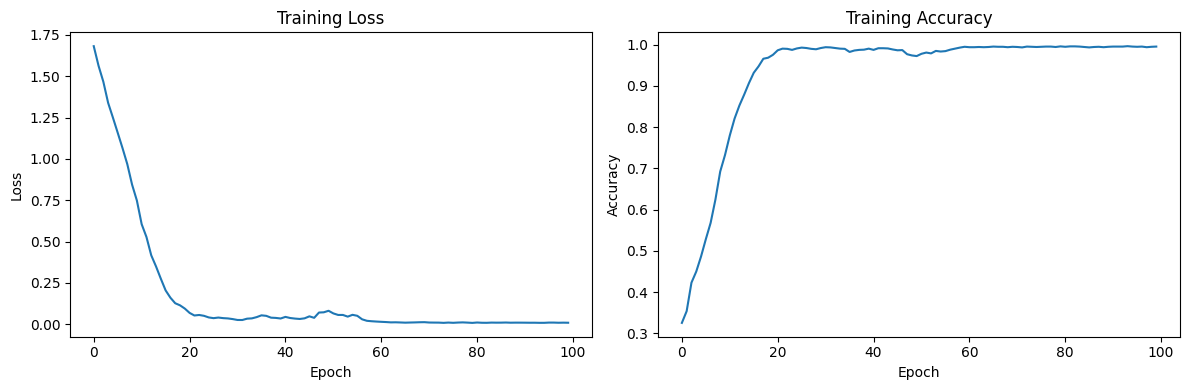

In [14]:
# Train the model
print("Training model...")
history = model.fit(
    dataset, 
    epochs=100,
    verbose=1
)

# Plot training history if you want
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()